In [1]:
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/gabriels3t/Classificacao-de-Jatos-utilizando-o-dataset-hls4ml-lhc-com-MLP-e-CNN--trabalho-.git
    import os as os
    os.chdir('./Classificacao-de-Jatos-utilizando-o-dataset-hls4ml-lhc-com-MLP-e-CNN--trabalho-')

Cloning into 'Classificacao-de-Jatos-utilizando-o-dataset-hls4ml-lhc-com-MLP-e-CNN--trabalho-'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 56 (delta 5), reused 16 (delta 2), pack-reused 34 (from 1)
Receiving objects: 100% (56/56), 603.92 MiB | 22.15 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (37/37), done.
Filtering content: 100% (4/4), 920.61 MiB | 48.17 MiB/s, done.


In [2]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


In [3]:
import pandas as pd
treino_df_arrumado = pd.read_csv('data/treino_preprocessado.csv')
teste_df_arrumado = pd.read_csv('data/teste_preprocessado.csv')

In [4]:
feature_treino = treino_df_arrumado.iloc[:, :-1]
label_treino = treino_df_arrumado.iloc[:, -1]
feature_teste = teste_df_arrumado.iloc[:, :-1]
label_teste = teste_df_arrumado.iloc[:, -1]


scaler = StandardScaler()
feature_treino_scaled = scaler.fit_transform(feature_treino)


feature_teste_scaled = scaler.transform(feature_teste)

In [5]:


model = XGBClassifier()

kf = StratifiedKFold(n_splits=5, shuffle=True)

cross_val_scores = []

for train_index, val_index in kf.split(feature_treino_scaled, label_treino):
    X_train, X_val = feature_treino_scaled[train_index], feature_treino_scaled[val_index]
    y_train, y_val = label_treino.iloc[train_index], label_treino.iloc[val_index]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    cross_val_scores.append(accuracy)

print(f'Média da acurácia da validação cruzada: {np.mean(cross_val_scores):.4f}')
print(f'Desvio padrão da acurácia: {np.std(cross_val_scores):.4f}')

model.fit(feature_treino_scaled, label_treino)

y_teste_pred = model.predict(feature_teste_scaled)
teste_accuracy = accuracy_score(label_teste, y_teste_pred)

print(f'Acurácia no conjunto de teste: {teste_accuracy:.4f}')



Média da acurácia da validação cruzada: 0.4683
Desvio padrão da acurácia: 0.0004
Acurácia no conjunto de teste: 0.4633


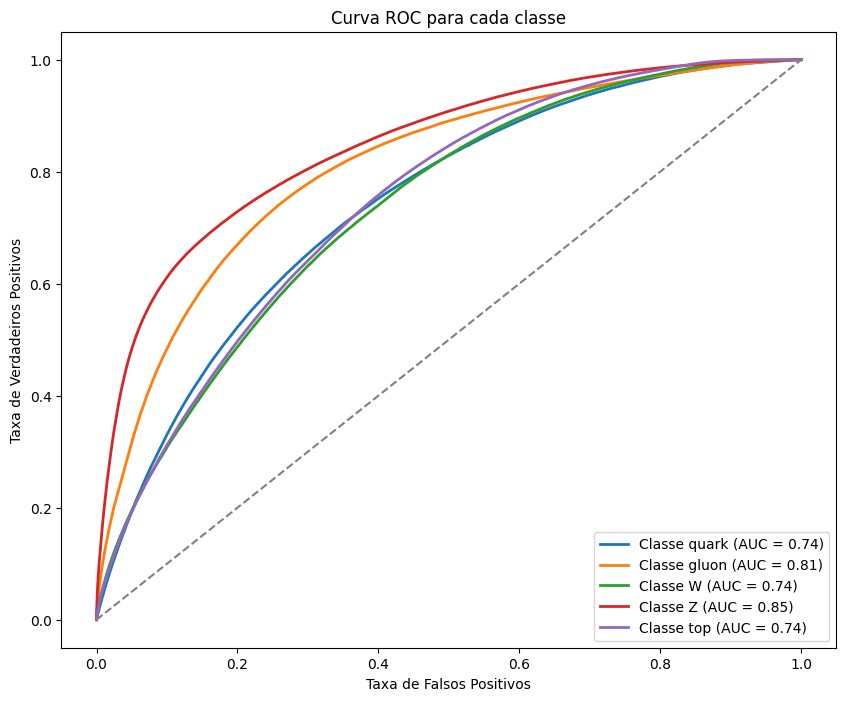

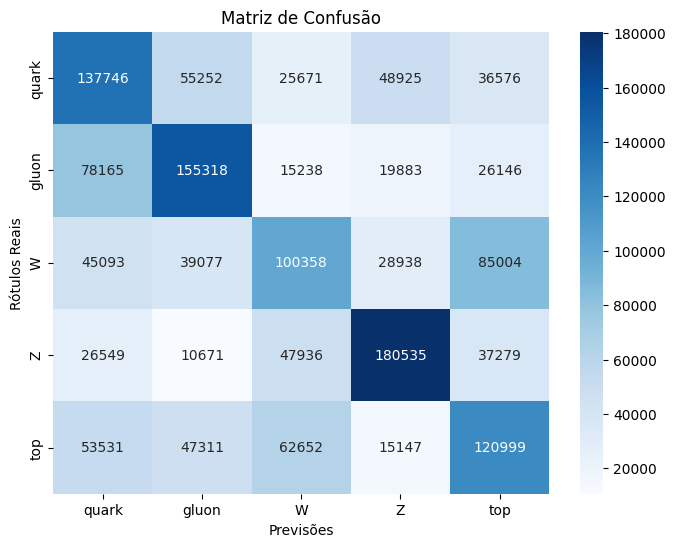

Acurácia no conjunto de teste: 0.4633


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Prevendo as probabilidades para calcular a Curva ROC (não apenas as classes)
y_teste_prob = model.predict_proba(feature_teste_scaled)

# Binarizando as labels para multi-classe (one-vs-rest)
y_teste_binarized = label_binarize(label_teste, classes=[0, 1, 2, 3, 4])

# Calculando a Curva ROC e a AUC para cada classe
fpr, tpr, roc_auc = {}, {}, {}

plt.figure(figsize=(10, 8))
classes = ["quark", "gluon", "W", "Z", "top"]
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_teste_binarized[:, i], y_teste_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Classe {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Curva ROC para todas as classes
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC para cada classe')
plt.legend(loc='lower right')
plt.show()

# Matriz de Confusão
y_teste_pred = model.predict(feature_teste_scaled)

# Gerando a Matriz de Confusão
cm = confusion_matrix(label_teste, y_teste_pred)

# Plotando a Matriz de Confusão com o seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["quark", "gluon", "W", "Z", "top"], yticklabels=["quark", "gluon", "W", "Z", "top"])
plt.xlabel('Previsões')
plt.ylabel('Rótulos Reais')
plt.title('Matriz de Confusão')
plt.show()

# Calculando a Acurácia no conjunto de teste (para referência)
teste_accuracy = accuracy_score(label_teste, y_teste_pred)
print(f'Acurácia no conjunto de teste: {teste_accuracy:.4f}')
